# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

100%|██████████████████████████████████████████████████████████████| 170498071/170498071 [00:10<00:00, 16062808.71it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

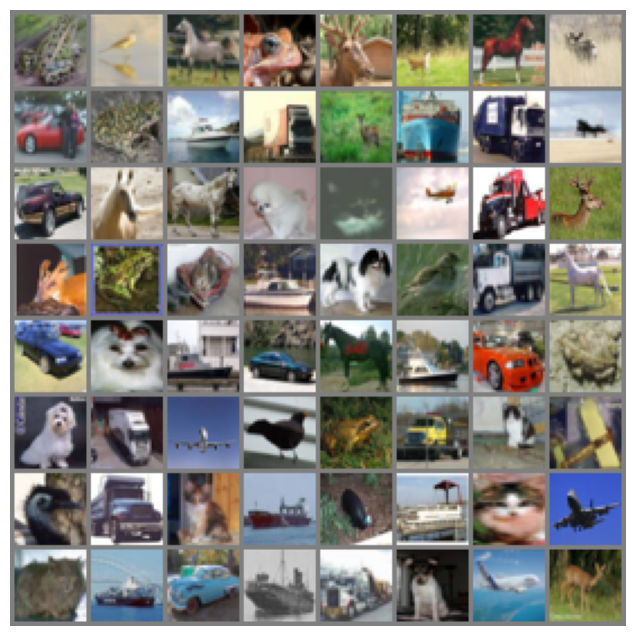

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [11]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 1024),
            nn.LeakyReLU(negative_slope=0.01)   ,
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [12]:
model = Model(n_classes)
device = torch.device('cpu')
model.to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.35, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.35, inplace=False)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Dropout(p=0.35, inplace=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): 

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [13]:

loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for classification problems
optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.90, 0.999), weight_decay=2.5e-4)


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [14]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.33619604 -0.1680896   0.16603035 -0.4267103  -0.4161768   0.06396718
  -0.02721061 -0.21528815 -0.3095215   0.00233113]
 [-0.17573413  0.5504497  -0.08769869 -0.13912332 -0.48522377 -0.39545083
  -0.47690022 -0.952693   -0.80278575  0.29354736]]
Output probabilities:
[[0.15018325 0.0907012  0.12668332 0.07003183 0.07077341 0.11439157
  0.10442296 0.08651969 0.078739   0.10755381]
 [0.09934603 0.20536582 0.10848853 0.10305057 0.07290224 0.07974964
  0.07351158 0.04567952 0.05306711 0.1588389 ]]


--------------Epoch: 1/10, Time: 41.13--------------
Step 0       training accuracy: 0.6094
             test accuracy: 0.5682
--------------Epoch: 1/10, Time: 506.45--------------
Step 500     training accuracy: 0.5769
             test accuracy: 0.5598
--------------Epoch: 2/10, Time: 959.07--------------
Step 1000    training accuracy: 0.6468
             test accuracy: 0.6418
--------------Epoch: 2/10, Time: 1434.11--------------
Step 1500    training accuracy: 0.6718
             test accuracy: 0.6554
--------------Epoch: 3/10, Time: 1909.45--------------
Step 2000    training accuracy: 0.7007
             test accuracy: 0.6999
--------------Epoch: 4/10, Time: 2393.46--------------
Step 2500    training accuracy: 0.7233
             test accuracy: 0.6981
--------------Epoch: 4/10, Time: 2875.96--------------
Step 3000    training accuracy: 0.7254
             test accuracy: 0.7213
--------------Epoch: 5/10, Time: 3346.66--------------
Step 3500    training accuracy: 0.7414
       

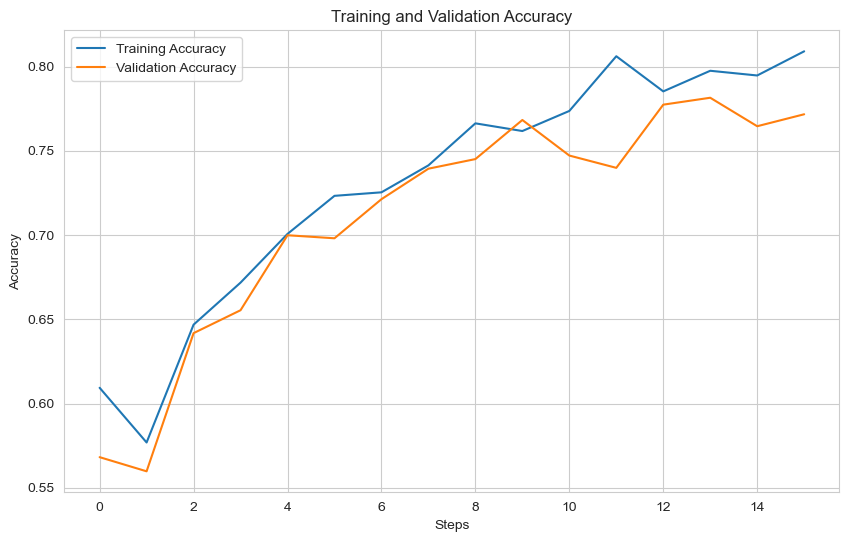

In [18]:
import time

num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

start_time  = time.time()

def accuracy(targets, predictions):
    return (targets == predictions).float().mean().item()

for epoch in range(num_epochs):
    train_accuracies_batches = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        loss = loss_fn(output, targets)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Compute accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []
            
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                model.train()
            
            end_time = time.time()  # Record end time
    
            epoch_duration = end_time - start_time
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
            print(f"--------------Epoch: {epoch+1}/{num_epochs}, Time: {epoch_duration:.2f}--------------")
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.4f}")
            print(f"             test accuracy: {valid_accuracies[-1]:.4f}")
        
        step += 1

print("Finished training.")

steps = list(range(len(valid_accuracies)))

plt.figure(figsize=(10, 6))
plt.plot(steps, train_accuracies, label='Training Accuracy')
plt.plot(steps, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

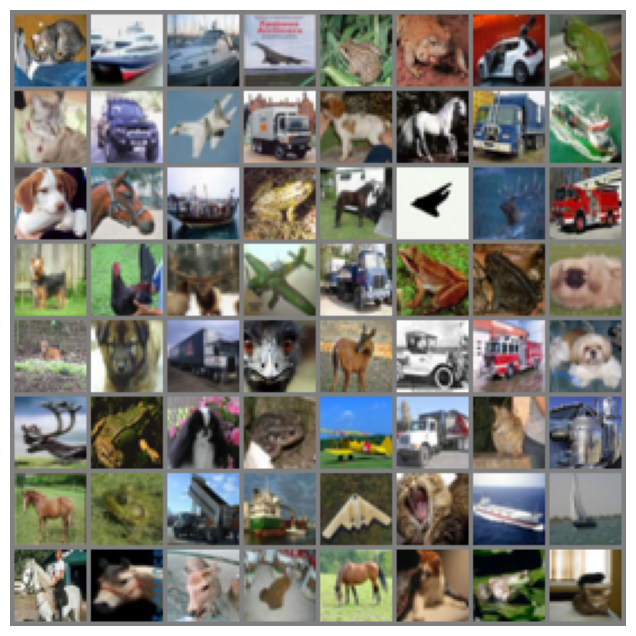

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog          bird     
    deer          deer     
     dog           d

In [19]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [20]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [21]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.760


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


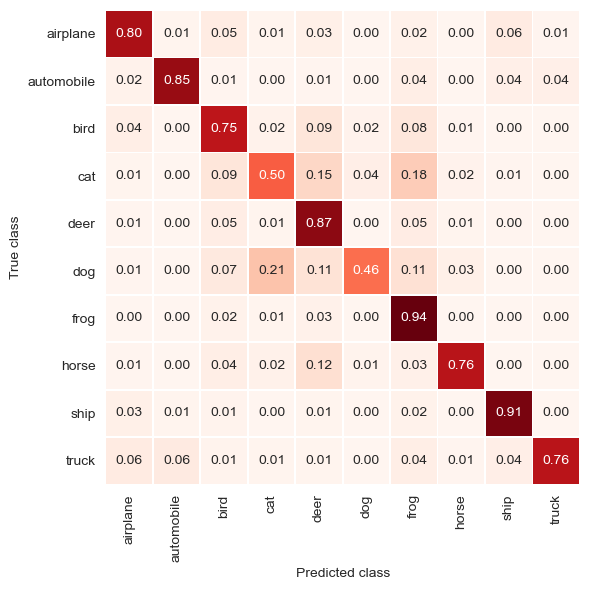

In [22]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

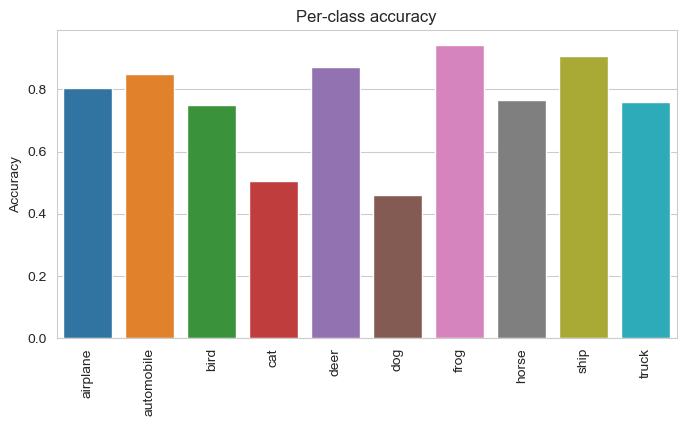

In [23]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

1. I used 4 convolutional layers. I trained for 10 epochs and managed to get a test accuracy of **0.76**.

2. I added several extra arguments and inputs to increase the models performance. I made sure to add dropout as well as weight decay. Before I added these regularization techniques the model overfitted severely. Especially when I had 4 convolutional layers. Then the model would severely overfit with a high training accuracy and with a test accuracy that wouldn't surpass 0.70 and it would eventually worsen even further over time (number of steps). However, the thing that seemed to surprise me the most was in fact that Leaky ReLU actually made a significant positive impact. Apparently this seems to indicate that the regular ReLU seemed to have a "dying ReLU problem" where it outputted many zeros because of neurons with negative inputs.

3. Key insights: Regularization of the model helped with preventing severe overfitting. Especially when making a very deep CNN. There, a deeper CNN is not necesarily a better one. Leaky ReLU also seemed to help with avoiding dead neurons and gave better generalization.  

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [15]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: []


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).


## **What classification accuracy do you get if you omit the fully-connected layer, and just use the convolutional-pooling layer and softmax layer? Does the inclusion of the fully-connected layer help?**


**Answer:**





In [107]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)  # Adjust the input size based on your data dimensions
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 128 * 16 * 16)  # Flatten the output for the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [108]:
loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for classification problems
optimizer = optim.Adam(model.parameters(), lr=0.001) 


In [109]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.23458448 -0.01348682 -0.24461111  0.09022243  0.1377841   0.03170604
  -0.22013187 -0.12346517  0.23388895 -0.13047858]
 [ 0.21371692 -0.04875543 -0.18835962  0.19318992  0.01982108  0.05619415
   0.02599843  0.13936734  0.11816408 -0.13643016]]
Output probabilities:
[[0.1247443  0.09733851 0.07725181 0.10797545 0.11323503 0.10183843
  0.07916622 0.08720105 0.12465756 0.08659162]
 [0.11811382 0.09084697 0.07900982 0.11571402 0.09729552 0.1008996
  0.09789841 0.10965063 0.10735015 0.08322117]]


In [110]:
batch_size = 64
num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.40821875
             test accuracy: 0.4524
Step 1000    training accuracy: 0.510536123853211
             test accuracy: 0.4825
Step 1500    training accuracy: 0.50840625
             test accuracy: 0.4943
Step 2000    training accuracy: 0.548774369266055
             test accuracy: 0.4934
Step 2500    training accuracy: 0.5982142857142857
             test accuracy: 0.4883
Step 3000    training accuracy: 0.57978125
             test accuracy: 0.4931
Step 3500    training accuracy: 0.6344926075268817
             test accuracy: 0.4813
Step 4000    training accuracy: 0.6868055555555556
             test accuracy: 0.4795
Step 4500    training accuracy: 0.66196875
             test accuracy: 0.4749
Step 5000    training accuracy: 0.7156554383116883
             test accuracy: 0.4703
Step 5500    training accuracy: 0.7788461538461539
             test accuracy: 0.4774
Step 6000    training accuracy: 0.745375
             test accuracy: 0.4709
Step 6500   

**Answer, Further Explained:**

In some cases omitting a fully connected layer can lead to much lower classification accuracies. In this case we get a test accuracy of only **46.12%**, which means that we are underfitting the model. The fully connected layer is used to flatten the high-dimensional feature maps from the convolutional layers and learn complex relationships between these features. Without the fully-connected layer, the model struggles to capture these intricate patterns, which in this case results in a poor performance.
